### Creating a MLP regression model with PyTorch
The first step is to import all the required dependencies. Then, we will use a Multilayer Perceptron based model, which is essentially a stack of layers containing neurons that can be trained.
We also have to ensure that the dataset is prepared into a DataLoader, which ensures that data is shuffled and batched appropriately.
Then, we pick a loss function and initialize it. We also init the model and the optimizer (Adam).
Finally, we create the training loop, which effectively contains the high-level training process captured in code.

In [13]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import pandas as pd
import MyData
import matplotlib.pyplot as plt

# Loading and preparing the data
personally I don't think normalization is needed for this project but here is the way:

In [14]:
df = pd.read_csv('dataset/alldata_up.csv')
# d = preprocessing.normalize(df, axis=0)
# scaled_df = pd.DataFrame(d, columns=names)
# scaled_df.head()

Splitting the dataset into test and train with 20% to 80% ratio using scikit-learn API. Then, saving them separately to directory.

In [15]:
train, test = train_test_split(df, test_size=0.2, shuffle=True)
train.to_csv('dataset/traindata.csv', index=False)
train.to_csv('dataset/testdata.csv', index=False)

Defining hyper parameters

In [16]:
learning_rate = 1e-6
batch_size = 20
number_of_labels = 3

Creating a loader for the test set which will read the data within batch size and put into memory.
Note that each shuffle is set to false for the test loader.

In [17]:
csv_path_train = 'dataset/traindata.csv'
train_data = MyData.GainDataset(csv_path_train)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
print("The tensor shape in a training set is: ", len(train_loader) * batch_size)

csv_path_test = 'dataset/testdata.csv'
test_data = MyData.GainDataset(csv_path_test)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)
print("The tensor shape in a test set is: ", len(test_loader) * batch_size)

The tensor shape in a training set is:  7000
The tensor shape in a test set is:  7000


# Defining the neural network
Because we are doing a simple regression, we are going to use one hidden layer

In [18]:
input_size = 3
output_size = 3

class Network(nn.Module):
    def __init__(self, input_size, output_size):
        super(Network, self).__init__()

        self.layer1 = nn.Linear(input_size, 64)
        self.layer2 = nn.Linear(64, 32)
        self.layer3 = nn.Linear(32, output_size)

    def forward(self, x):
        x1 = nn.functional.relu(self.layer1(x))
        x2 = nn.functional.relu(self.layer2(x1))
        x3 = self.layer3(x2)
        return x3

# Instantiate the model
model = Network(input_size, output_size)

Define your execution device

In [19]:
device = torch.device("cpu")
print("The model will be running on", device, "device\n")
model.to(device)  # Convert model parameters and buffers to CPU or Cuda

The model will be running on cpu device



Network(
  (layer1): Linear(in_features=3, out_features=64, bias=True)
  (layer2): Linear(in_features=64, out_features=32, bias=True)
  (layer3): Linear(in_features=32, out_features=3, bias=True)
)

Function to save the model

In [20]:
def saveModel():
    path = "trainedmodels/model2.pth"
    torch.save(model.state_dict(), path)

Define the loss function with Classification Cross-Entropy loss and an optimizer with Adam optimizer

In [21]:
loss_fn = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.0001)

## Training Function

In [22]:
def train(num_epochs):

    print("Begin training...")
    for epoch in range(1, num_epochs + 1):
        running_train_loss = 0.0

        # Training Loop
        for data in train_loader:
            # for data in enumerate(train_loader, 0):
            inputs, outputs = data
            optimizer.zero_grad()  # zero the parameter gradients
            predicted_outputs = model(inputs)  # predict output from the model
            train_loss = loss_fn(predicted_outputs, outputs)  # calculate loss for the predicted output
            train_loss.backward()  # backpropagation
            optimizer.step()  # adjust parameters based on the calculated gradients
            running_train_loss += train_loss.item()  # track the loss value

        # Calculate training loss value
        train_loss_value = running_train_loss / len(train_loader)

        # here, a validation loop can be added
        # ...

        saveModel()

        # Print the statistics of the epoch
        print('Completed training batch', epoch, 'Training Loss is: %.4f' % train_loss_value)

## Testing

In [23]:
def test():
    # Load the model that we saved at the end of the training loop
    model = Network(input_size, output_size)
    path = "trainedmodels/model2.pth"
    model.load_state_dict(torch.load(path))
    model.eval()
    running_accuracy = 0

    with torch.no_grad():
        for data in test_loader:
            inputs, outputs = data
            outputs = outputs.to(torch.float32)
            predicted_outputs = model(inputs)
            error = predicted_outputs - outputs # honestly I dont know what to do with the error nor how to interpret it haha:))
            running_accuracy = mean_squared_error(outputs, predicted_outputs)

        print('Accuracy of the model based on the test set of', len(test_loader) * batch_size,
              'inputs is: %d %%' % running_accuracy) # this should somehow be in percents

        plt.plot(inputs, predicted_outputs, color='k')

        plt.show()

Now, we run the main program:

Begin training...
Completed training batch 1 Training Loss is: 1.8976
Completed training batch 2 Training Loss is: 1.8921
Completed training batch 3 Training Loss is: 1.8873
Completed training batch 4 Training Loss is: 1.8830
Completed training batch 5 Training Loss is: 1.8801
Completed training batch 6 Training Loss is: 1.8789
Completed training batch 7 Training Loss is: 1.8712
Completed training batch 8 Training Loss is: 1.8669
Completed training batch 9 Training Loss is: 1.8642
Completed training batch 10 Training Loss is: 1.8556
Completed training batch 11 Training Loss is: 1.8566
Completed training batch 12 Training Loss is: 1.8518
Completed training batch 13 Training Loss is: 1.8437
Completed training batch 14 Training Loss is: 1.8415
Completed training batch 15 Training Loss is: 1.8367
Completed training batch 16 Training Loss is: 1.8336
Completed training batch 17 Training Loss is: 1.8251
Completed training batch 18 Training Loss is: 1.8216
Completed training batch 19 Training 

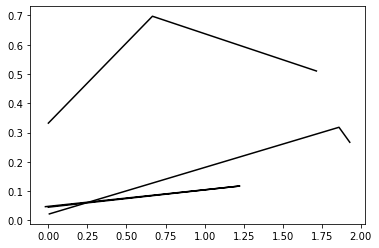

In [24]:
if __name__ == "__main__":
    torch.manual_seed(42)
    num_epochs = 40
    train(num_epochs)
    print('Finished Training\n')
    test()

# Loading and using the model
** Please refer to gettingoutputs.py **